In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-07-06_22-22_20180601_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

YM       0.25
ES       0.25
GC       0.25
NQ       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    22802.60
GC     9549.44
NQ    34341.80
YM    29139.80
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

95833.64

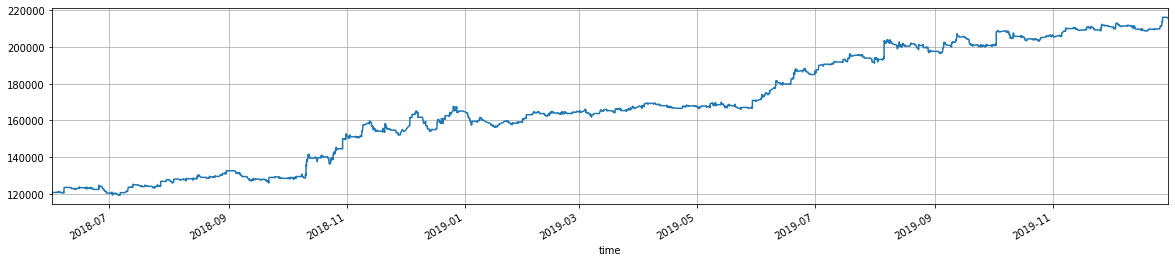

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     344
 GC     868
 NQ    1892
 YM     462
 Name: action, dtype: int64, 3566)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    0.834951
 GC    2.106796
 NQ    4.592233
 YM    1.121359
 Name: action, dtype: float64, 8.655339805825243)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     722.40
GC    2100.56
NQ    3973.20
YM     970.20
Name: commission, dtype: float64

In [15]:
df.commission.sum()

7766.3600000000015

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.38,22.00,476.24,-262.11,1.82,18.46,434.0
NQ,0.41,36.30,456.51,-252.08,1.81,38.44,946.0
YM,0.44,126.15,763.99,-378.19,2.02,124.37,231.0
ES,0.45,132.57,984.76,-558.15,1.76,136.16,172.0
total,0.41,53.75,559.57,-297.73,1.88,53.76,1783.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,-0.050365,0.190874,0.490685,0.689255
GC,-0.050365,1.000000,0.045278,0.039135,0.349023
NQ,0.190874,0.045278,1.000000,0.255293,0.665463
YM,0.490685,0.039135,0.255293,1.000000,0.721700
total,0.689255,0.349023,0.665463,0.721700,1.000000


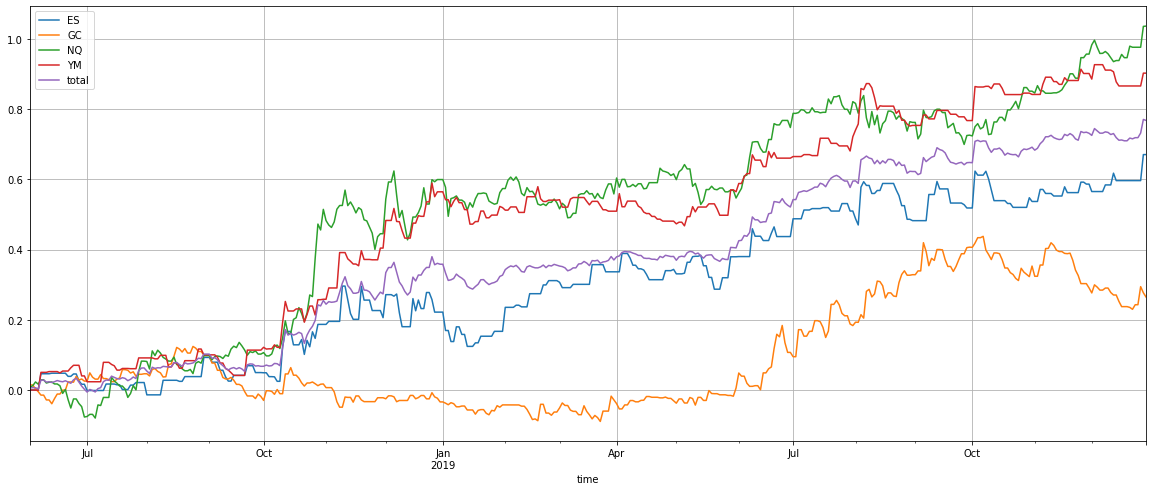

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

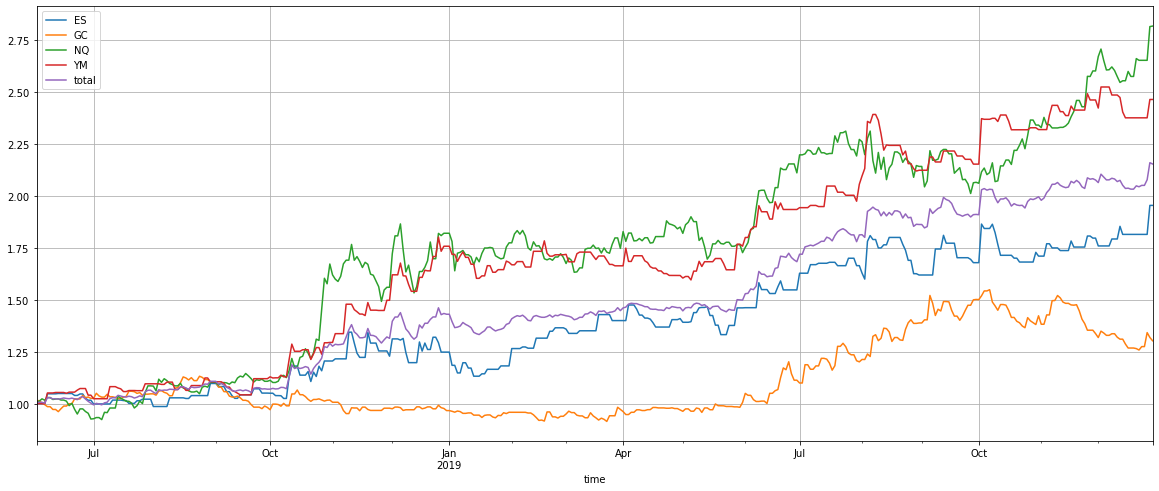

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.506822,0.175675,0.884725,0.736425,0.599117
Cumulative returns,0.954867,0.302909,1.818439,1.465008,1.154407
Annual volatility,0.335850,0.258743,0.365047,0.293285,0.194599
Sharpe ratio,1.384269,0.752473,1.918032,2.025719,2.510148
Calmar ratio,3.212571,0.913661,4.968685,6.430339,6.740518
Stability,0.941261,0.509210,0.893287,0.935321,0.964845
Max drawdown,-0.157762,-0.192276,-0.178060,-0.114523,-0.088883
Omega ratio,1.464539,1.167023,1.447039,1.710048,1.659026
Sortino ratio,2.840509,1.398099,3.332226,4.545703,5.308058
Skew,2.171188,1.655835,0.781140,2.285588,1.829471


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,1.65,2.56,-7.40,4.09,0.22
2018-07-31,0.49,2.12,17.25,5.26,6.25
2018-08-31,7.41,5.52,1.57,0.87,4.01
2018-09-30,-4.22,-11.16,0.45,1.36,-3.41
2018-10-31,14.71,3.62,51.00,15.58,20.61
2018-11-30,1.92,-3.84,-6.70,15.69,1.89
2018-12-31,1.60,-1.18,16.67,17.38,8.82
2019-01-31,-5.32,-0.84,-2.53,-4.41,-3.06
2019-02-28,15.53,-2.01,-3.95,2.16,2.86


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        95.0
GC        30.0
NQ       182.0
YM       147.0
total    115.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-08-05 21:22:30,ES,BUY,2843.00,3408.3
2019-10-02 21:00:00,ES,BUY,2893.75,3320.8
2019-08-05 21:19:00,YM,BUY,25615.00,3190.8
2018-11-08 20:40:00,YM,SELL,26092.00,3180.8
2018-11-09 09:08:00,ES,SELL,2796.25,3170.8
...,...,...,...,...
2018-12-18 21:49:00,ES,BUY,2559.75,-1204.2
2018-12-20 12:21:30,ES,BUY,2508.00,-1204.2
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.2


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-08-05,0.113610,0.022011,0.035793,0.106360,0.069444
2019-10-02,0.110693,0.012183,0.026633,0.101693,0.062801
2018-12-03,0.067777,-0.002989,0.103553,0.081860,0.062550
2018-10-11,0.044580,0.057849,0.050440,0.061913,0.053696
2018-10-10,0.103193,0.000000,0.030073,0.073053,0.051580
...,...,...,...,...,...
2019-01-02,-0.050973,-0.003495,-0.021780,-0.022307,-0.024639
2018-11-13,-0.038890,-0.000989,-0.043200,-0.017613,-0.025173
2018-10-22,-0.041530,-0.009161,-0.021920,-0.037113,-0.027431
